# Tutorial
Let's work through a simple example and analyze the Schrute dataset a little bit.

In [ ]:
using Cairo
using DataFrames
using DataFramesMeta
using Gadfly
using Schrute
using Statistics
using Query

We grab the dataset with the one function the package exports

In [ ]:
df = Schrute.theOffice();
first(df, 7)

Doesn't tell us much, let's look at the structure a bit

In [ ]:
describe(df)

So we have all the text from the entire series. Each record is a line, with various attributes such as character name, etc. There are attributes that are at the episode-level such as writer, episode, etc. which we can access by grouping functions, which we'll cover in a bit.

Now to ask some basic questions of the data.

## What is the mean imdb score per season?
We all know the last few seasons were the worst, let's see if the collective wisdom of imdb supports that hunch.

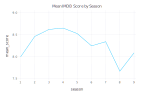

In [17]:
one = @linq df |>
    by(:season, mean_score = mean(:imdb_rating)) |>
    select(:season, :mean_score) |>
    plot(x=:season, y=:mean_score, Geom.line, Guide.xticks(ticks=collect(1:9)), Guide.title("Mean IMDB Score by Season"))

one
# draw(PNG("images/1.png", 6inch, 4inch), one)

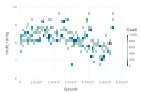

In [16]:
two = plot(
    df,
    x=:index,
    y=:imdb_rating,
    Geom.histogram2d(xbincount=50, ybincount=20),
    Guide.xlabel("Episode")
)

two

# draw(PNG("images/2.png", 6inch, 4inch), two)

Yep, that checks out!

## Who has the most lines in the series?

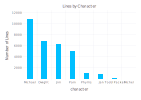

In [20]:
foo = by(df, :character,  nrow)[1:8,:]
sort!(foo, :x1, rev = true)
rename!(foo, Dict(:x1 => "Number of Lines"))

mytheme = Theme(bar_spacing=25pt);

three = plot(foo,
     x=:character,
     y=:"Number of Lines",
     Geom.bar,
     Guide.yticks(ticks=[2000,4000,6000,8000,10000,12000]),
     Guide.title("Lines by Character"),
     mytheme
)

three
 
# draw(PNG("images/3.png", 6inch, 4inch), three)


## That's what she said
Who said this the most? It's obvious Michael Scarn but let's see for sure

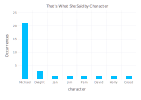

In [23]:
twss = []
for line in df[:,:text]
    # println(line)
    try
        foo = occursin("what she said", line)
        # println(foo)
        push!(twss, string(foo))
    catch
        push!(twss, "false")
        continue
    end
end

df[:,:twss] = twss

twss_df = @linq df |>
    where(:twss .== "true") 

twss_toplot =  by(twss_df, :character, nrow)
rename!(twss_toplot, Dict(:x1 => "Occurrences"))

four = plot(twss_toplot,
     x=:character,
     y=:Occurrences,
     Geom.bar,
     Guide.yticks(ticks=[5,10,15,20,25]),
     Guide.title("That's What She Said by Character"),
     mytheme
)

four
# draw(PNG("images/4.png", 6inch, 4inch), four)

## How are the imdb ratings distributed across seasons?

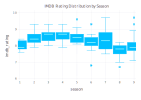

In [24]:
plot(df,
    x=:season,
    y=:imdb_rating,
    Geom.boxplot,
    Guide.xticks(ticks=collect(1:9)),
    Guide.title("IMDB Rating Distribution by Season")
)


There's a few low-scoring outliers in seasons 6 and 8, I'm curious which episodes those were...

In [25]:
df_worst = @linq df |>
    # groupby([:episode_name, :season]) |>
    by([:episode_name, :season], score = mean(:imdb_rating))


df_worst = @linq df_worst |>
    groupby(:season) |>
    transform(min_sc = minimum(:score)) |>
    where(:min_sc .== :score) |>
    select(:season, :episode_name, :score)


,season,episode_name,score
,Int64,String,Float64
1,1,Pilot,7.6
2,2,The Carpet,7.9
3,3,Grief Counseling,8.0
4,3,Diwali,8.0
5,4,Job Fair,7.9
6,5,Employee Transfer,8.1
7,5,Blood Drive,8.1
8,6,The Banker,6.8
9,7,Christening,7.5


Ahh, looks like "Get the girl" in season 8 wasn't great, as well as "The Banker" in season 6. If we had a way of quantifying "cringe", no doubt Scott's Tots would be at the top!

## Schrute in python and R
The Schrute package is also available in [R](https://bradlindblad.github.io/schrute/) and [Python](https://github.com/bradlindblad/schrutepy)